In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

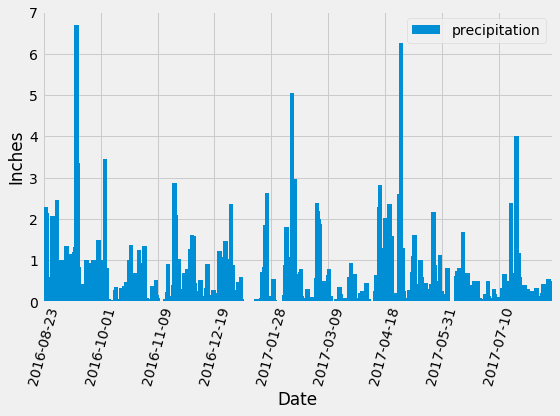

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_str=str(last_date)[2:-3]
last_date_obj=dt.datetime.strptime(last_date_str,'%Y-%m-%d').date()
query_date=last_date_obj - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
#sel = [Measurement.date, func.sum(Measurement.prcp)]
last12months = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last12months_df = pd.DataFrame(last12months, columns=['Date', 'precipitation'])

# Sort the dataframe by date
last12months_sort=last12months_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
# resource: nice source for x-axis tickers https://www.geeksforgeeks.org/matplotlib-ticker-maxnlocator-class-in-python/
from matplotlib.ticker import MaxNLocator, IndexFormatter 
last12months_sort.set_index('Date', inplace=True)
ax = last12months_sort.plot.bar(figsize=[8,6], grid=True, width=20)
ax.xaxis.set_major_locator(MaxNLocator(nbins=9)) 
ax.xaxis.set_major_formatter(IndexFormatter(last12months_sort.index))
plt.xticks(rotation = 75)
plt.ylabel("Inches")
plt.tight_layout()
plt.show();

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last12months_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations_count=session.query(Measurement).group_by(Measurement.station).count()
print(f'Number of stations available in the dataset: {stations_count}')

Number of stations available in the dataset: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.tobs)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
results = session.query(*sel).\
        filter(Measurement.station=='USC00519281').all()
results = pd.DataFrame(results, columns=['station', 'min_tobs', 'max_tobs', 'avg_tobs'])
results

,station,min_tobs,max_tobs,avg_tobs
0,USC00519281,54.0,85.0,71.663781


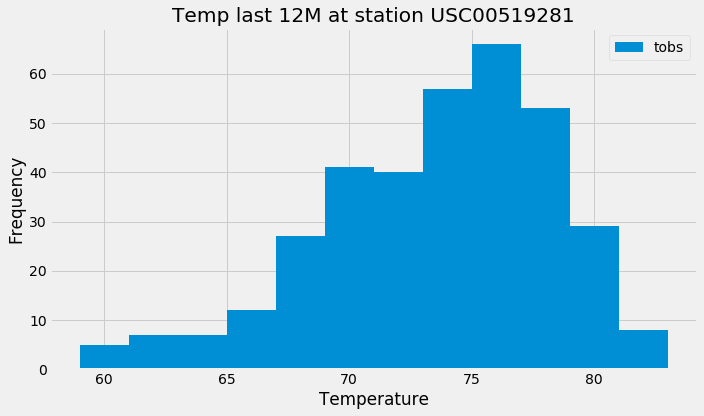

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = pd.DataFrame(session.query(Measurement.tobs).\
        filter(Measurement.station=='USC00519281').\
        filter(Measurement.date >= query_date).all())

temperatures.plot.hist(bins=12, figsize=[10,6])
plt.title("Temp last 12M at station USC00519281")
plt.xlabel("Temperature")
plt.tight_layout()
plt.show();

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [19]:
# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title

# Use the average temperature for the y value

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
